In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import numpy
import os
import time
import matplotlib.pyplot

In [2]:
train_dataset = torchvision.datasets.CIFAR10(root = os.getcwd(), train = True, download = True, transform = torchvision.transforms.ToTensor())
buck = [[] for _ in range(3)]
for i, l in train_dataset:
    buck[0].append(i[0])
    buck[1].append(i[1])
    buck[2].append(i[2])
buck[0] = torch.stack(buck[0])
buck[1] = torch.stack(buck[1])
buck[2] = torch.stack(buck[2])
params = [buck[i].mean().item() for i in range(3)]
stds = [buck[i].std().item() for i in range(3)]
params, stds

Files already downloaded and verified


([0.4913996756076813, 0.48215848207473755, 0.44653090834617615],
 [0.24703224003314972, 0.24348513782024384, 0.26158785820007324])

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


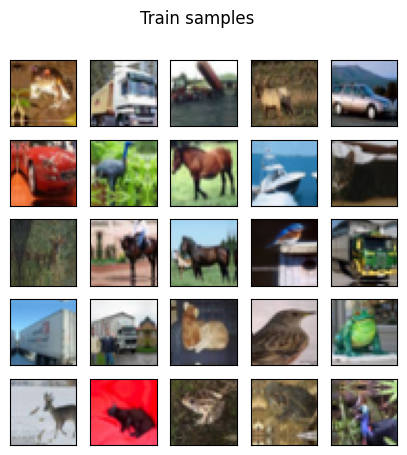

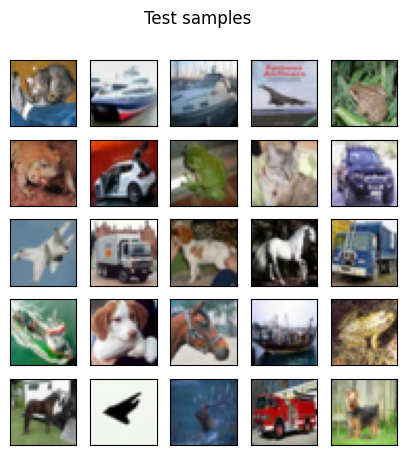

In [3]:
names = ('frog', 'dog', 'plane', 'car', 'cat', 'deer', 'bird', 'horse', 'ship', 'truck')
train_transforms = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), torchvision.transforms.RandomHorizontalFlip(), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(params, stds, inplace=True)])
test_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(params, stds, inplace=True)])
train_dataset = torchvision.datasets.CIFAR10(root = os.getcwd(), train = True, download = True, transform = train_transforms)
test_dataset = torchvision.datasets.CIFAR10(root = os.getcwd(), train = False, download = True, transform = test_transforms)

def denorm(image, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return image * stds + means

def show_images(images, title):
    fig, axes = matplotlib.pyplot.subplots(5, 5, figsize = (5, 5))
    fig.suptitle(title)
    matplotlib.pyplot.setp(matplotlib.pyplot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = denorm(images[i][0], params, stds)
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))
print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')
print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

Label: 9


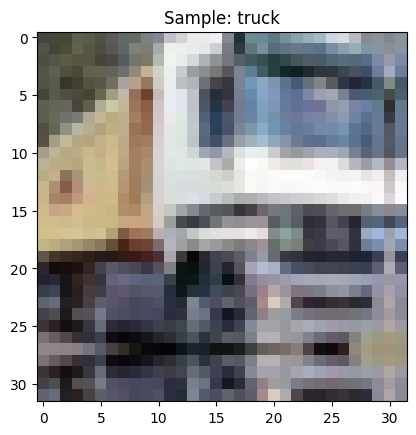

In [4]:
def view_image(image, title):
    img = denorm(image[0], params, stds)
    img = img.numpy().transpose(1, 2, 0)
    matplotlib.pyplot.title("{}: {}".format(title, names[image[1]]))
    matplotlib.pyplot.imshow((img * 255).astype('uint8'))

ind = 1
view_image(train_dataset[ind], 'Sample')
print('Label: {}'.format(train_dataset[ind][1]))

In [5]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256, shuffle = False)

class ResNet10(torch.nn.Module):
    def __init__(self):
        super(ResNet10, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(3, 64, kernel_size=3, padding=1), torch.nn.BatchNorm2d(64), torch.nn.ReLU(inplace=True))
        self.conv_and_pool_1 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(64, 128, kernel_size=3, padding=1), torch.nn.BatchNorm2d(128), torch.nn.ReLU(inplace=True)), torch.nn.MaxPool2d(kernel_size=2))
        self.res1 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(128, 128, kernel_size=3, padding=1), torch.nn.BatchNorm2d(128), torch.nn.ReLU(inplace=True)), torch.nn.Sequential(torch.nn.Conv2d(128, 128, kernel_size=3, padding=1), torch.nn.BatchNorm2d(128), torch.nn.ReLU(inplace=True)))
        self.conv_and_pool_2 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(128, 256, kernel_size=3, padding=1), torch.nn.BatchNorm2d(256), torch.nn.ReLU(inplace=True)), torch.nn.MaxPool2d(kernel_size=2))
        self.conv_and_pool_3 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(256, 512, kernel_size=3, padding=1), torch.nn.BatchNorm2d(512), torch.nn.ReLU(inplace=True)), torch.nn.MaxPool2d(kernel_size=2))
        self.res2 = torch.nn.Sequential(torch.nn.Sequential(torch.nn.Conv2d(512, 512, kernel_size=3, padding=1), torch.nn.BatchNorm2d(512), torch.nn.ReLU(inplace=True)), torch.nn.Sequential(torch.nn.Conv2d(512, 512, kernel_size=3, padding=1), torch.nn.BatchNorm2d(512), torch.nn.ReLU(inplace=True)))
        self.final_pool = torch.nn.MaxPool2d(kernel_size=4)
        self.dense = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Dropout(0.2), torch.nn.Linear(512, 10))

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv_and_pool_1(out)
        out = self.res1(out) + out
        out = self.conv_and_pool_2(out)
        out = self.conv_and_pool_3(out)
        out = self.res2(out) + out
        out = self.final_pool(out)
        out = self.dense(out)
        return out

cnn_model = ResNet10()
cnn_model

ResNet10(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_and_pool_1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [6]:
loss_function = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
device

device(type='cuda')

In [9]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def train(cnn_model, data_loader, epochs, loss_function, optimizer, device):
    start = time.time()
    for epoch in range(epochs):
        startep = time.time()
        accs = []
        lss = []
        for i, (images, labels) in enumerate(data_loader):
            labels = labels.to(device)
            images = images.to(device)
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = loss_function(outputs, labels)
            acc = accuracy(outputs, labels)
            lss.append(loss)
            accs.append(acc)
            loss.backward()
            optimizer.step()
            endep = time.time()
        print('Epoch {}: loss = {}, acc = {}, time = {}'.format(epoch + 1, torch.stack(lss).mean(), torch.stack(accs).mean(), endep-startep))
    end = time.time()
    print('Total time {}'.format(end - start))

train(cnn_model, train_data_loader, 50, torch.nn.CrossEntropyLoss(), torch.optim.Adam(cnn_model.parameters(), lr = 0.001), device)

Epoch 1: loss = 0.5652029514312744, acc = 0.803483784198761, time = 46.48563766479492
Epoch 2: loss = 0.4911200702190399, acc = 0.8308873176574707, time = 40.26034688949585
Epoch 3: loss = 0.4352332055568695, acc = 0.848828136920929, time = 40.88313865661621
Epoch 4: loss = 0.39826568961143494, acc = 0.8628268241882324, time = 40.27056646347046
Epoch 5: loss = 0.3493347764015198, acc = 0.880090057849884, time = 39.99641227722168
Epoch 6: loss = 0.32302001118659973, acc = 0.8886878490447998, time = 39.92407202720642
Epoch 7: loss = 0.29903146624565125, acc = 0.8956153988838196, time = 40.13850808143616
Epoch 8: loss = 0.28127092123031616, acc = 0.9030174016952515, time = 40.36824941635132
Epoch 9: loss = 0.25175583362579346, acc = 0.911324143409729, time = 39.722861766815186
Epoch 10: loss = 0.2439887672662735, acc = 0.9154098033905029, time = 39.97203302383423
Epoch 11: loss = 0.2151397317647934, acc = 0.9254185557365417, time = 39.938493490219116
Epoch 12: loss = 0.20110037922859192, 

In [10]:
print('Loss = {}, acc = {}'.format(get_loss(cnn_model, test_data_loader, device), get_accuracy(cnn_model, test_data_loader, device)))

Loss = 0.0016844383208081126, acc = 0.911899983882904
